In [1]:
import pandas as pd
import numpy as np

In [2]:
def loadCSV(path):
    data = pd.read_csv(path)
    return data

In [3]:
def dataCleaning(data):
    print("na values available in data \n")
    print(data.isna().sum())
    data = data.dropna()
    print("after droping na values \n")
    print(data.isna().sum())
    return data

In [4]:
def preprocessing(data):
    data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])
    
    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1=data.join(cat_list)
        data=data1

    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    data_vars=data.columns.values.tolist()
    to_keep=[i for i in data_vars if i not in cat_vars]
    
    final_data=data[to_keep]
    
    
    final_data.columns = final_data.columns.str.replace('.','_')
    final_data.columns = final_data.columns.str.replace(' ','_')
    return final_data

In [5]:
def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
    return X_train, X_test, y_train, y_test

In [6]:
def over_sampling_trarget_class(X_train, y_train):
    ### Over-sampling using SMOTE 
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
    print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
    print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
    print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['y']
 
    return X_train, y_train

In [7]:
def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    
    return model

In [8]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [9]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
def get_metrics(y_true, y_pred, y_pred_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [10]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.plot_roc_curve(clf, X_data, y_data) 
    plt.savefig('roc_auc_curve.png')

In [11]:
def create_confusion_matrix_plot(clf, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(clf, X_test, y_test)
    plt.savefig('confusion_matrix.png')

In [12]:
def hyper_parameter_tuning(X_train, y_train):
    # define random parameters grid
    n_estimators = [5,20,50,100] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

In [30]:
def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    import mlflow
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

In [14]:
data = loadCSV('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv')

In [15]:
cleaned_data = dataCleaning(data)

na values available in data 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
after droping na values 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [16]:
final_data = preprocessing(cleaned_data)

C:\Users\Ashutosh Tripathi\AppData\Local\Temp\ipykernel_72268\4067079169.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_data.columns = final_data.columns.str.replace('.','_')


In [17]:
X_train, X_test, y_train, y_test = train_test_split(final_data)

In [18]:
X_train, y_train = over_sampling_trarget_class(X_train, y_train)

length of oversampled data is  51166
Number of no subscription in oversampled data 25583
Number of subscription 25583
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [19]:
model = training_basic_classifier(X_train,y_train)

In [20]:
y_pred = predict_on_test_data(model,X_test)

In [21]:
y_pred_prob = predict_prob_on_test_data(model,X_test) #model.predict_proba(X_test)

In [22]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

C:\Users\Ashutosh Tripathi\anaconda3\envs\mlops\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


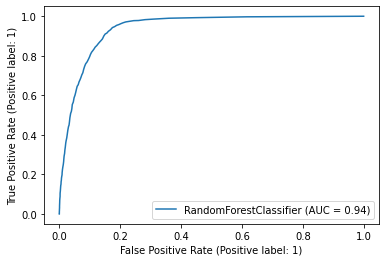

In [23]:
create_roc_auc_plot(model, X_test, y_test)

C:\Users\Ashutosh Tripathi\anaconda3\envs\mlops\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


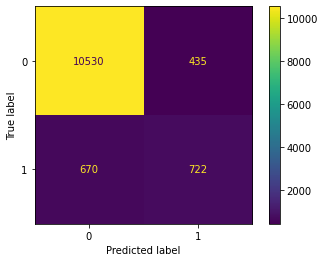

In [24]:
create_confusion_matrix_plot(model, X_test, y_test)

In [25]:
experiment_name = "TermDepositSubscription"
run_name="term_deposit"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

In [26]:
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png', 'roc_auc_curve.png')

Run - term_deposit is logged to Experiment - TermDepositSubscription


C:\Users\Ashutosh Tripathi\anaconda3\envs\mlops\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [27]:
import mlflow
experiment_name = "TermDepositSubscription"
run_name="Random_Search_CV_Tuned_Model"
model_tuned,best_params = hyper_parameter_tuning(X_train, y_train)
run_params = best_params

y_pred = predict_on_test_data(model_tuned,X_test) #will return the predicted class
y_pred_prob = predict_prob_on_test_data(model_tuned,X_test) #model.predict_proba(X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}  



In [28]:
for param in run_params:
    print(param, run_params[param])

n_estimators 20
min_samples_split 2
min_samples_leaf 1
max_features sqrt
max_depth 80
bootstrap True


In [32]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png', 'roc_auc_curve.png',run_params)

2022/07/04 01:09:19 INFO mlflow.tracking.fluent: Experiment with name 'TermDepositSubscription' does not exist. Creating a new experiment.


Run - Random_Search_CV_Tuned_Model is logged to Experiment - TermDepositSubscription
